In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:

import os
import sys
import json

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [33]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [34]:
# where WellClass and Ga[ codes are located
sys.path.append('../src')

In [35]:
# WellClass
# from well_class_v2 import csv_parser, Well
from WellClass.libs.utils import (
    csv_parser,
    yaml_parser
)

from WellClass.libs.well_class import Well
from WellClass.libs.well_pressure import Pressure

# plots
from WellClass.libs.plotting import (
    plot_pressure,
    plot_pt,
    plot_sketch,
)

## Some user options

In [36]:
# use yaml or csv input file
use_yaml = False

In [37]:
# pick an example from given three options

case_type = 'cosmo'

case_type = 'smeaheia_v1'

case_type = 'smeaheia_v2'

case_type = 'frigg'

In [38]:
# where pvt located
pvt_path = '../test_data/pvt_constants/'

# Examples

The following are the test examples.

In [39]:
# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
               'sim_path': r'../test_data/examples/smeaheia_v1',
               'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
               'sim_path': r'../test_data/examples/smeaheia_v2', 
               'simcase': r'TEMP-0'}
cosmo = {
         'well_input': r'GaP_input_Cosmo_v3.csv', 
         'well_input_yaml': r'cosmo.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/cosmo', 
         'simcase': r'TEMP-0'}

frigg = {
         'well_input': r'GaP_input_Frigg_v3.csv', 
         'sim_path': r'../test_data/examples/frigg', }

In [40]:
examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'cosmo': cosmo,
    'frigg': frigg
}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [41]:
# the selected example for testing
case = examples[case_type]


In [42]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

sim_path = case['sim_path']


In [43]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)

In [44]:
#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
           )

In [45]:
my_pressure = Pressure(
    header      = well_csv['well_header'],
    reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path,
)

Hydrostatic pressure at reference depth 1217 is 120.23
RP1 set as hydrostatic P = 120.23 bar
RP2 is set as delta pressure, which yields P = 120.23 +10.00 = 130.23 bar
Reference depth: 1217.0


# Visualization

## to do
Verify cement plugs computation

In [46]:
a ="Wellname       UWN            UTMnorth       UTMeast        MeasDepth(m)   MeasTVD(m)     Dip            Azimuth        Location(NS)   Location(EW)   Dogleg"
a.split()


['Wellname',
 'UWN',
 'UTMnorth',
 'UTMeast',
 'MeasDepth(m)',
 'MeasTVD(m)',
 'Dip',
 'Azimuth',
 'Location(NS)',
 'Location(EW)',
 'Dogleg']

In [47]:
import welly
import numpy as np

w = welly.Well()
survey = np.loadtxt(r'../test_data/examples/frigg/X_5687dev.txt', skiprows=1, dtype={'names':('Wellname',
                                                                                     'UWN',
                                                                                     'UTMnorth',
                                                                                     'UTMeast',
                                                                                     'MeasDepth(m)',
                                                                                     'MeasTVD(m)',
                                                                                     'Dip',
                                                                                     'Azimuth',
                                                                                     'Location(NS)',
                                                                                     'Location(EW)',
                                                                                     'Dogleg'),
                                                                             'formats':['|S10']+10*[float]})


w.location.add_deviation(  np.stack([survey['MeasDepth(m)'], survey['Dip'],survey['Azimuth']]).T, td=4721)

t = w.location.trajectory(elev=True, datum=(0, 0, my_well.header['well_rkb']))

w.location.md2tvd(4451)

array(4445.94119583)

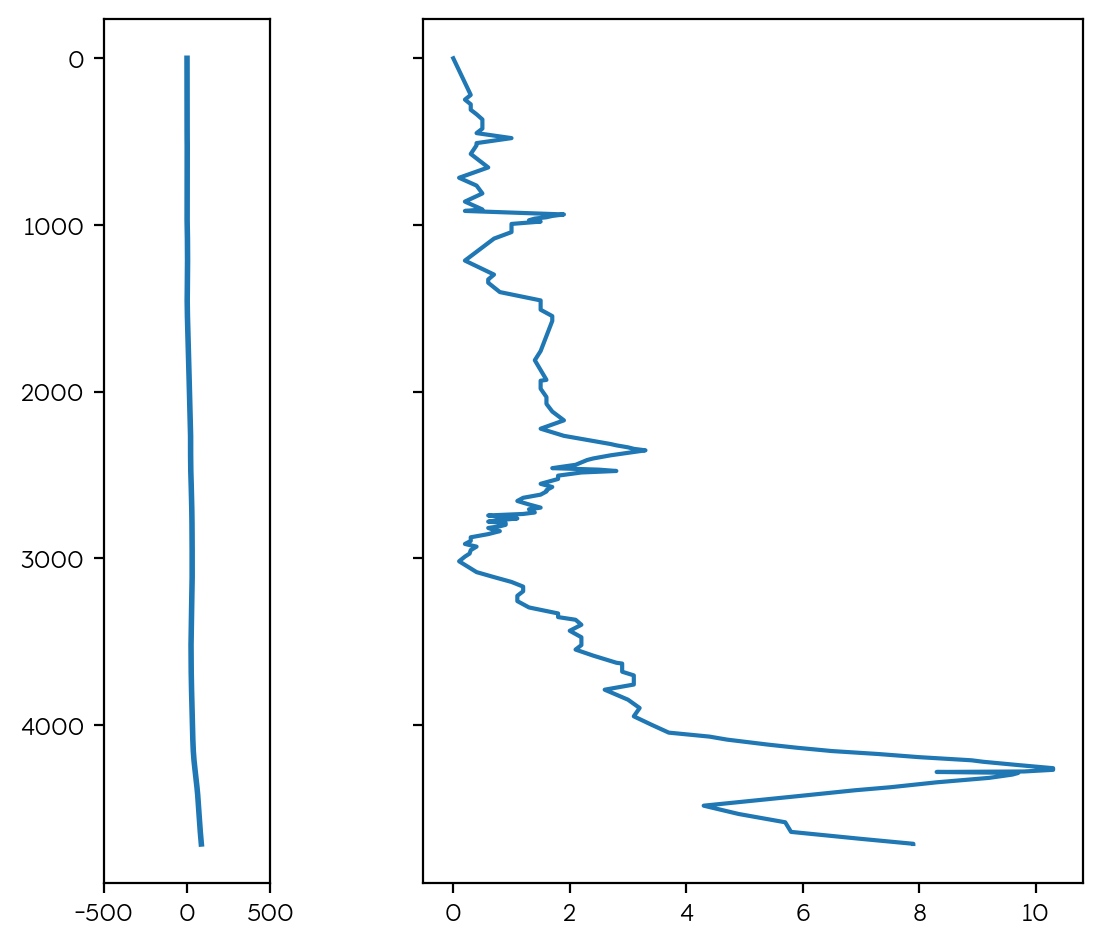

In [48]:
fig, (ax, ax2) = plt.subplots(1,2,sharey=True)
#MD
md_welly = w.location.deviation[:, 0]
w.location.tvd

#Horizontal offset of the well
os = np.sqrt(w.location.position[:,0]**2+w.location.position[:,1]**2)

ax.plot(os, w.location.tvd, lw=2, label="welly")

ax2.plot(w.location.deviation[:, 1], w.location.tvd, )
ax.set_xlim(-500, 500)
ax.set_aspect(1)
ax.invert_yaxis()

fig.tight_layout()


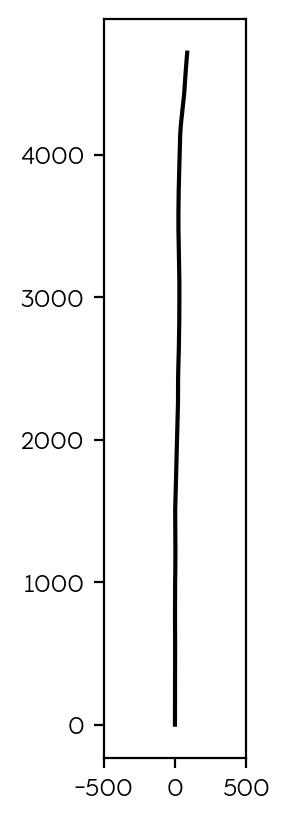

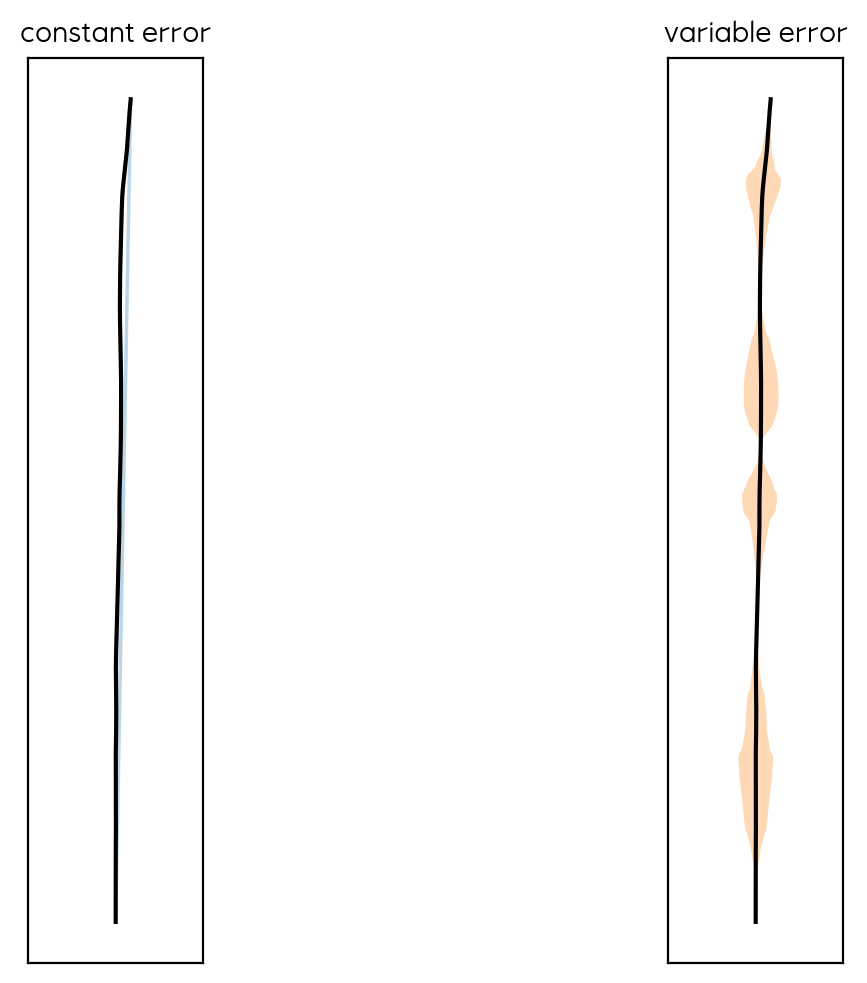

In [49]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

N = 400
t = np.linspace(0, 2 * np.pi, N)
r = 0.5 + np.cos(t)
x, y = r * np.cos(t), r * np.sin(t)
x, y = os, w.location.tvd
t = np.linspace(0, 2 * np.pi, len(x))

fig, ax = plt.subplots()
ax.plot(x, y, "k")
ax.set(aspect=1)
ax.set_xlim(-500, 500)

def draw_error_band(ax, x, y, err, **kwargs):
    # Calculate normals via centered finite differences (except the first point
    # which uses a forward difference and the last point which uses a backward
    # difference).
    dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
    dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
    l = np.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l

    # end points of errors
    xp = x + nx * err
    yp = y + ny * err
    xn = x - nx * err
    yn = y - ny * err

    vertices = np.block([[xp, xn[::-1]],
                         [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, **kwargs))


_, axs = plt.subplots(1, 2, layout='constrained', sharex=True, sharey=True)
errs = [
    (axs[0], "constant error", 10),
    (axs[1], "variable error", 100 * np.sin(2 * t) ** 2 + 0.04),
]
for i, (ax, title, err) in enumerate(errs):
    ax.set(title=title, aspect=1, xticks=[], yticks=[])
    ax.plot(x, y, "k")
    draw_error_band(ax, x, y, err=err,
                    facecolor=f"C{i}", edgecolor="none", alpha=.3)
    
    ax.set_xlim(-500, 500)

plt.show()

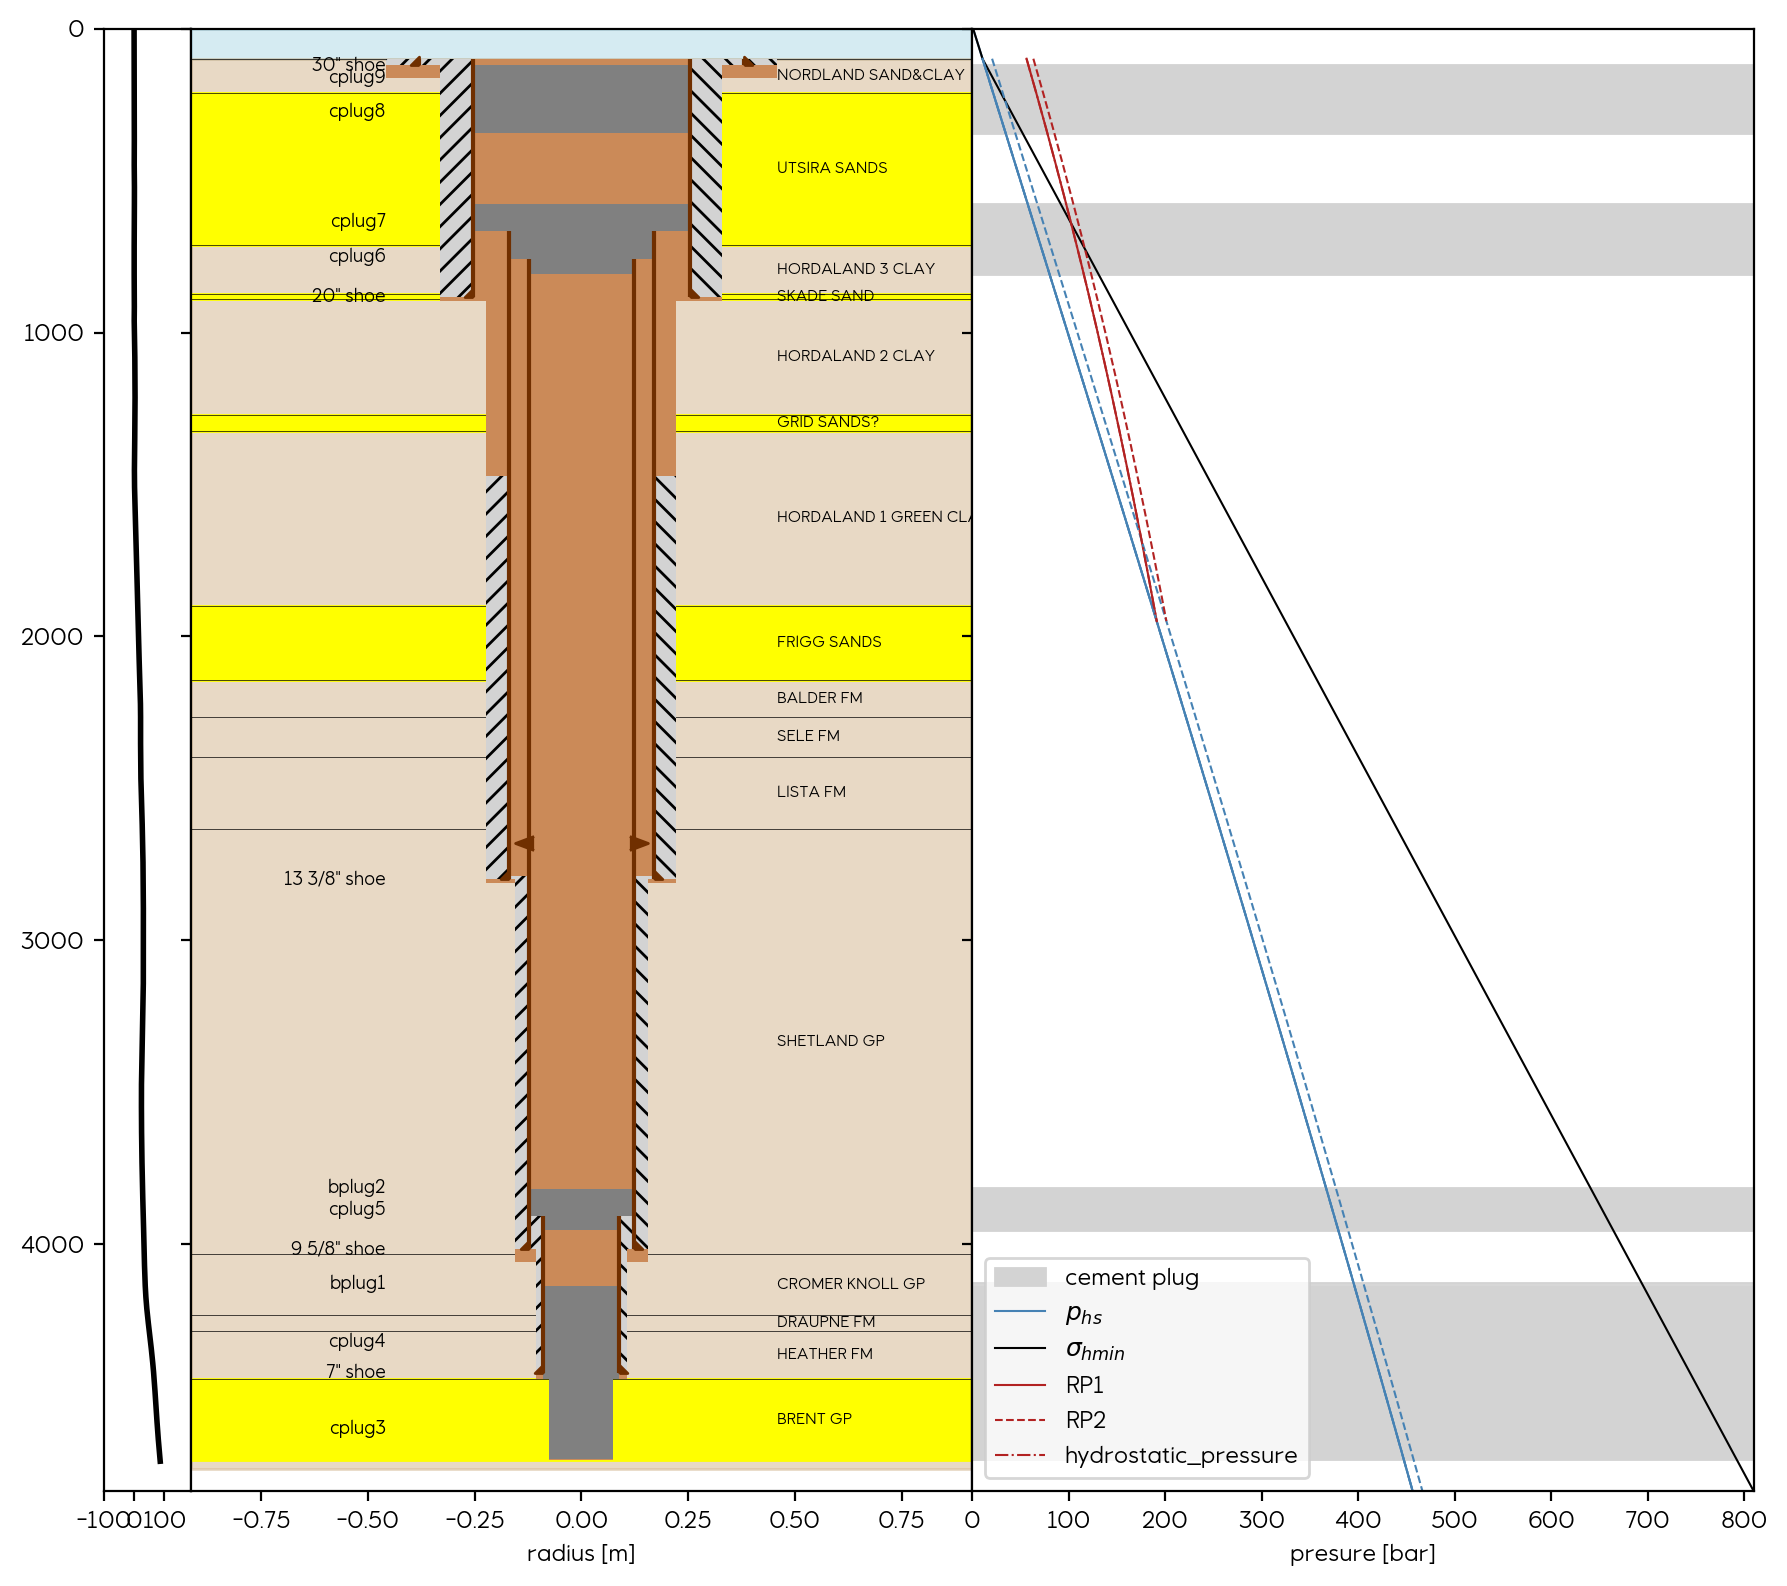

In [50]:
import pandas as pd


#Plot sketch, pressures
fig, (ax0, ax1, ax2) = plt.subplots(1,3, sharey=True, figsize=(10, 8))
plot_sketch(my_well, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2)

ax0.plot(os, w.location.tvd, lw=2, label="welly", c='k')
# ax0.scatter([250,-250],[0,0])
ax0.set_aspect(1)
# ax0.set_axis_off()
ax0.set_xlim(os.min()-100, os.max()+100)



#Draw casing shoes
perf_size = 2
left_perf = [[perf_size/3, -perf_size/2], [-perf_size, 0], [perf_size/3, perf_size/2]]
right_perf = [[-perf_size/3, -perf_size/2], [perf_size, 0], [-perf_size/3, perf_size/2]]

casings_df  = pd.DataFrame(my_well.casings)

shoe_query = casings_df[casings_df['shoe']]
steelcolor = '#702F00'
ax1.scatter( ((9+5/8)*0.0254)/2, 2705-23.5, marker = right_perf, s=100, c=steelcolor, zorder=100, facecolors='none')
# ax1.scatter([-((9+5/8)*0.0254)/2, -((9+5/8)*0.0254)/2], [2705-23.5, 2805-23.5], marker = left_perf, s=100, c=steelcolor, zorder=100)
step_z = 50
perf_top = 2705-23.5
perf_bottom = 2705-23.5
perf_z = np.arange(start = perf_top, stop = perf_bottom+step_z,step = step_z)

ax1.plot([-((9+5/8)*0.0254)/2]*len(perf_z), perf_z, marker = left_perf, ms=10, c=steelcolor, zorder=100)

# for idx, row in shoe_query.iterrows():
#         ycoord = row['bottom_msl']
#         d_in = row['diameter_in']
#         shoe_label = float_to_fraction_inches(d_in)+' shoe'
#         ax.annotate(shoe_label, xy = (xcoord_left, ycoord), fontsize = txt_fs_left, va = 'center', ha='right')




fig.tight_layout()
fig.subplots_adjust(wspace=0)

#routine to stretch ax1 and ax2 while keeping the first aspect ratio

pos_left = ax0.get_position()  # Get the original position
pos_right = ax1.get_position()
gap = pos_right.x0 - pos_left.x1     # Calculate the gap between the subplots

ax1.set_position([pos_right.x0 - gap, pos_right.y0, pos_right.width+gap/2, pos_right.height])

pos_left = ax1.get_position()  # Get the original position
pos_right = ax2.get_position()
gap = pos_right.x0 - pos_left.x1     # Calculate the gap between the subplots

ax2.set_position([pos_right.x0 - gap, pos_right.y0, pos_right.width+gap, pos_right.height])



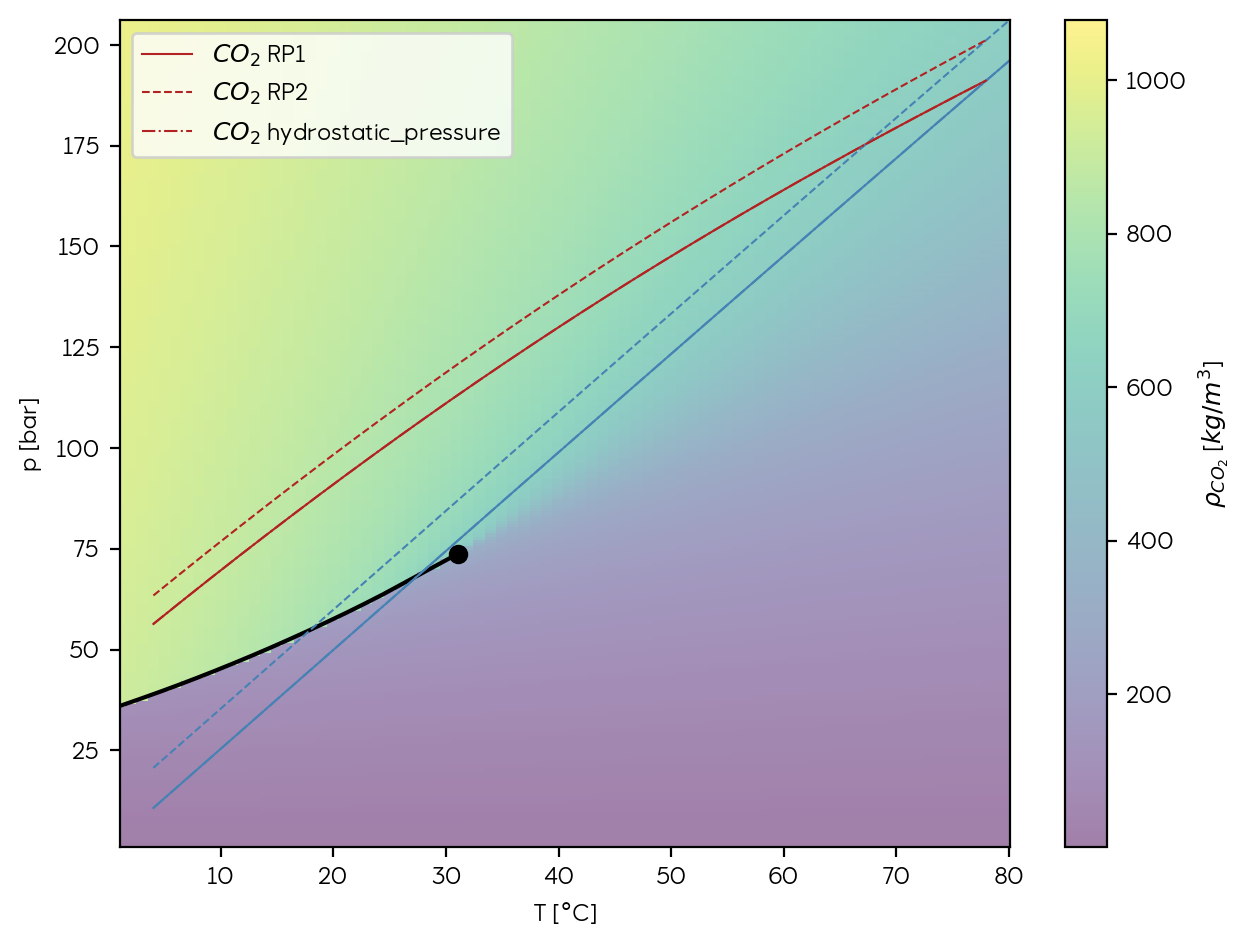

In [61]:
plot_pt(my_pressure)

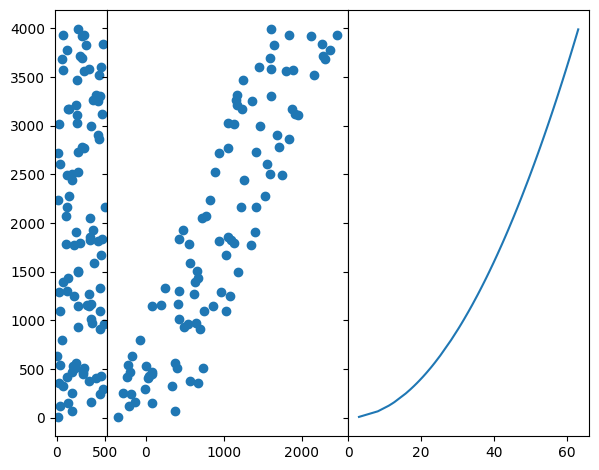

In [7]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(seed=1000)

fig, (ax0, ax1, ax2) = plt.subplots(1,3, sharey = True)

#values for first plot
x0 = np.random.uniform(0, 500, size = 100) 
y0 = np.random.uniform(0, 4000, size = 100)

#values for second plot
x1 = (y0/2)+np.random.uniform(-500, 500, size = 100) 
y1 = y0

#values for third plot
x2 = np.sqrt(np.sort(y0))
y2 = np.sort(y0)

#Plot data
ax0.scatter(x0,y0)
ax0.set_aspect(1) #keep aspect ratio in plot 1
ax1.scatter(x1, y1)

ax2.plot(x2,y2)

fig.tight_layout()
fig.subplots_adjust(wspace=0)

pos0 = ax0.get_position()  # Get the original position
pos1 = ax1.get_position()

gap01 = pos1.x0 - pos0.x1     # Calculate the gap between the subplots
ax1.set_position([pos1.x0 - gap01, pos1.y0, pos1.width+gap01/2, pos1.height])

pos0 = ax1.get_position()  # Get the original position
pos1 = ax2.get_position()
gap01 = pos1.x0 - pos0.x1     # Calculate the gap between the subplots

ax2.set_position([pos1.x0 - gap01, pos1.y0, pos1.width+gap01, pos1.height])


# ax2.set_position([pos2.x0 - gap, pos2.y0, pos2.width, pos2.height])